In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers as L, Model
from tensorflow.keras.metrics import BinaryAccuracy, Precision, BinaryIoU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [29]:
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available: 1


In [5]:
# --- Data Loading Utility ---
def load_masks(mask_dir, image_size=(256, 256)):
    mask_files = sorted(os.listdir(mask_dir))
    masks = []

    for mask_file in mask_files:
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size)
        mask = (mask / 255.0).astype(np.uint8)  # Ensure binary
        masks.append(mask)

    return np.expand_dims(np.array(masks, dtype=np.float32), -1)

def load_images(image_dir, image_size=(256, 256)):
    image_files = sorted(os.listdir(image_dir))
    images = []

    for img_file in image_files:
        img = cv2.imread(os.path.join(image_dir, img_file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, image_size) / 255.0
        images.append(img)

    return np.expand_dims(np.array(images, dtype=np.float32), -1)

# --- Plotting Utilities ---
def plot_image_mask(idx, X, Y, title=""):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(X[idx].squeeze(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(Y[idx].squeeze(), cmap='gray')
    plt.suptitle(title)
    plt.show()

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.4*bce + 0.6*dice

# --- Model Building Blocks ---
def conv_block(x, filters):
    for _ in range(2):
        x = L.Conv2D(filters, 3, padding="same")(x)
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = L.MaxPool2D((2, 2))(c)
    return c, p

def attention_gate(g, s, filters):
    g1 = L.BatchNormalization()(L.Conv2D(filters, 1, padding="same")(g))
    s1 = L.BatchNormalization()(L.Conv2D(filters, 1, padding="same")(s))
    out = L.Activation("relu")(g1 + s1)
    out = L.Activation("sigmoid")(L.Conv2D(filters, 1, padding="same")(out))
    return out * s

def decoder_block(x, s, filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, filters)
    x = L.Concatenate()([x, s])
    return conv_block(x, filters)

def attention_unet(input_shape):
    inputs = L.Input(input_shape)
    c0, p0 = encoder_block(inputs, 32)
    c1, p1 = encoder_block(p0, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    c5 = conv_block(p4, 1024)
    u1 = decoder_block(c5, c4, 512)
    u2 = decoder_block(u1, c3, 256)
    u3 = decoder_block(u2, c2, 128)
    u4 = decoder_block(u3, c1, 64)
    u5 = decoder_block(u4, c0, 32)
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(u5)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(0.001),
              loss=combined_dice_bce_loss,
              metrics=[
                  BinaryIoU(target_class_ids=[0, 1], threshold=0.5),
                  BinaryAccuracy(),
                  Precision()
              ])

    return model

# --- Plot Training Metrics ---
def plot_metrics(history, metric_name, ylabel, ylim=None):
    plt.figure()
    plt.plot(history.epoch, history.history[metric_name], 'b', label='Training')
    plt.plot(history.epoch, history.history[f"val_{metric_name}"], 'r', label='Validation')
    plt.title(f'Training and Validation {metric_name.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.show()

# --- Predict and Visualize Test Results ---
def visualize_prediction(idx, model, X, Y):
    pred = model.predict(np.expand_dims(X[idx], axis=0)).squeeze()
    gt = Y[idx].squeeze()
    diff = np.stack([gt, gt, pred], axis=-1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(X[idx].squeeze(), cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(gt, cmap='gray')
    plt.subplot(1, 4, 3)
    plt.title("Prediction")
    plt.imshow(pred, cmap='gray')
    plt.subplot(1, 4, 4)
    plt.title("Differences")
    plt.imshow(diff)
    plt.show()

# --- Evaluate with DICE ---
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1 * mask2)
    return round((2 * intersect) / (np.sum(mask1) + np.sum(mask2) + 1e-7), 3)


--- Processing Channel: gray ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 34s 267ms/step - loss: 0.3509 - binary_io_u: 0.7180 - binary_accuracy: 0.9221 - precision: 0.6575 - val_loss: 0.7012 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 19s 260ms/step - loss: 0.2387 - binary_io_u: 0.7834 - binary_accuracy: 0.9464 - precision: 0.7838 - val_loss: 0.7567 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 264ms/step - loss: 0.2135 - binary_io_u: 0.7954 - binary_accuracy: 0.9499 - precision: 0.7993 - val_loss: 0.8237 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.7482
Epoch 4/50
75/75 [==============================] - 20s 264ms/step - loss: 0.2076 - binary_io_u: 0.7974 - binary_accu

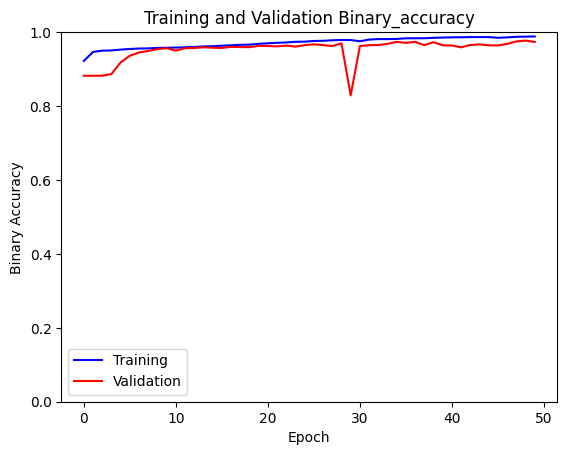

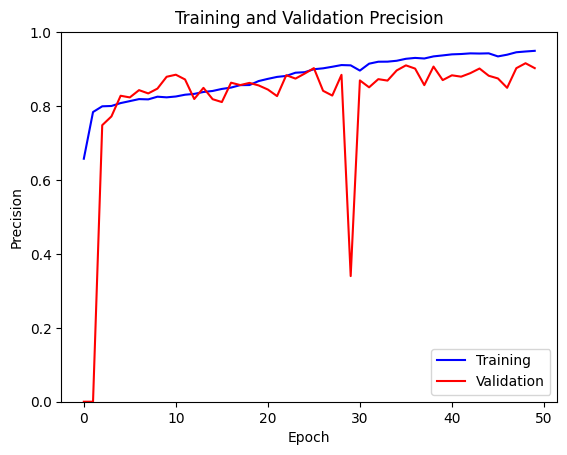

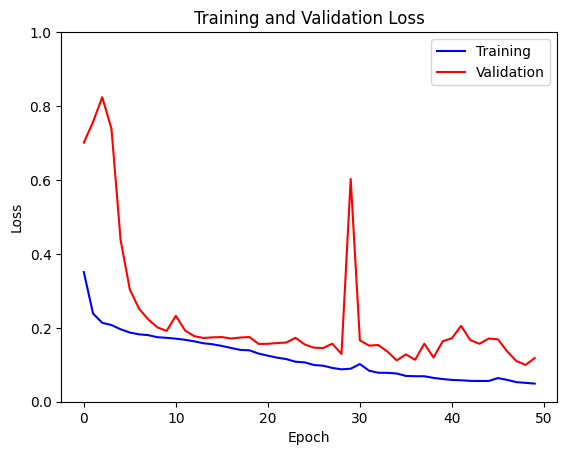

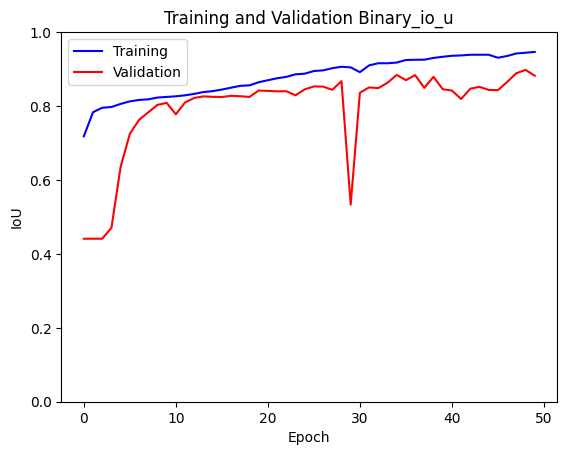

1/1 [==============================] - 0s 16ms/step
gray - Avg DICE Score: 0.8639749999999999
gray - Max DICE Score: 0.917
gray - Min DICE Score: 0.697
gray - Std DICE Score: 0.046076831217001034

--- Processing Channel: RGB_B ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 24s 282ms/step - loss: 0.4260 - binary_io_u: 0.6619 - binary_accuracy: 0.8976 - precision: 0.5571 - val_loss: 0.6699 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 284ms/step - loss: 0.2904 - binary_io_u: 0.7481 - binary_accuracy: 0.9360 - precision: 0.7418 - val_loss: 0.7299 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 283ms/step - loss: 0.2526 - binary_io_u: 0.7678 - binary_accuracy: 0.9422 - precision: 0.7709 - val_loss: 0.7953 

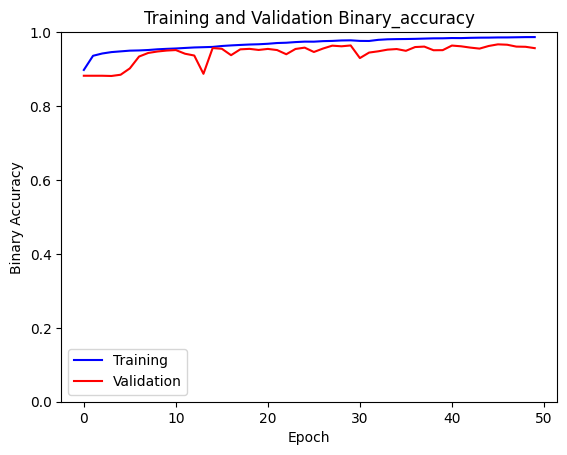

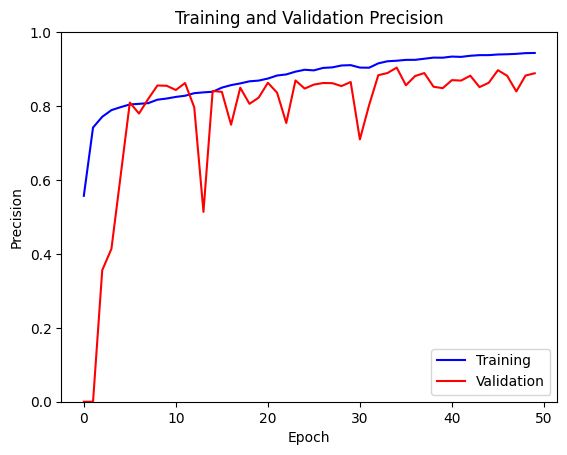

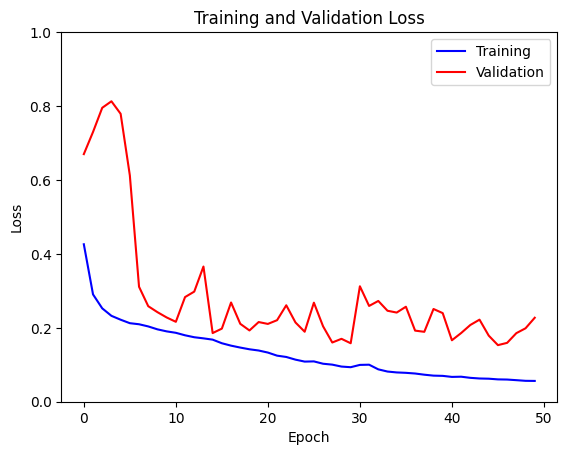

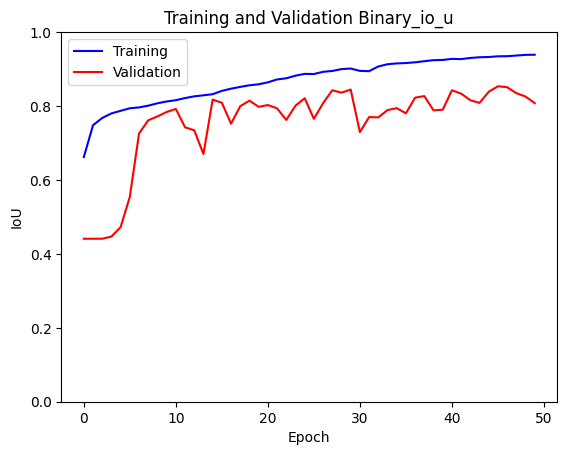

1/1 [==============================] - 0s 18ms/step
RGB_B - Avg DICE Score: 0.752325
RGB_B - Max DICE Score: 0.88
RGB_B - Min DICE Score: 0.411
RGB_B - Std DICE Score: 0.11744773039526989

--- Processing Channel: RGB_G ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 273ms/step - loss: 0.4529 - binary_io_u: 0.6925 - binary_accuracy: 0.9037 - precision: 0.5681 - val_loss: 0.6686 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 276ms/step - loss: 0.3053 - binary_io_u: 0.7801 - binary_accuracy: 0.9441 - precision: 0.7587 - val_loss: 0.7134 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 284ms/step - loss: 0.2542 - binary_io_u: 0.7844 - binary_accuracy: 0.9464 - precision: 0.7805 - val_loss: 0.7699 - val_bi

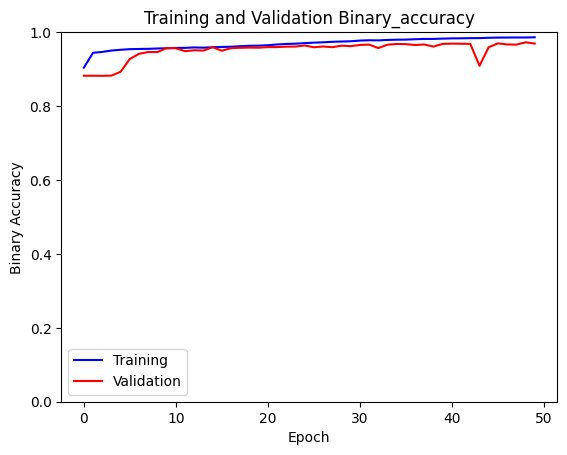

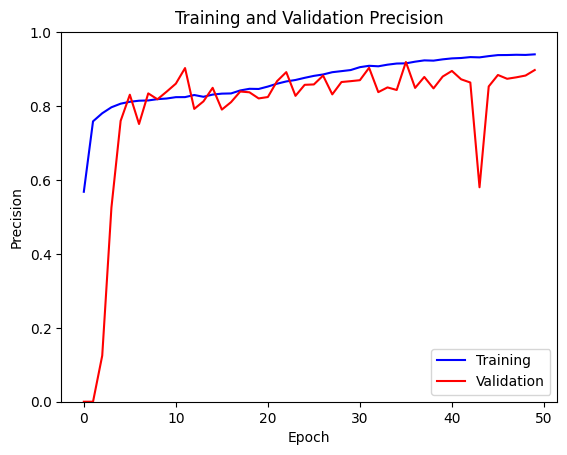

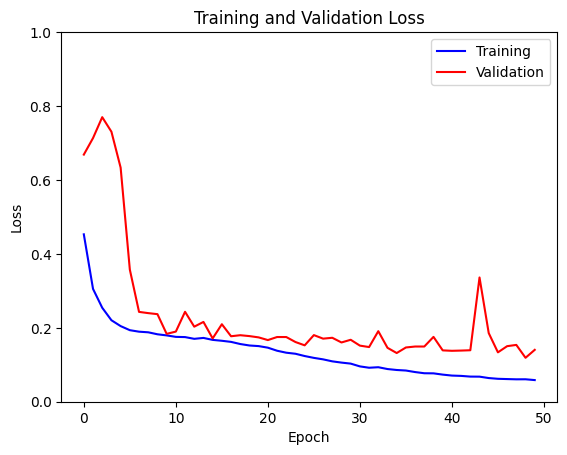

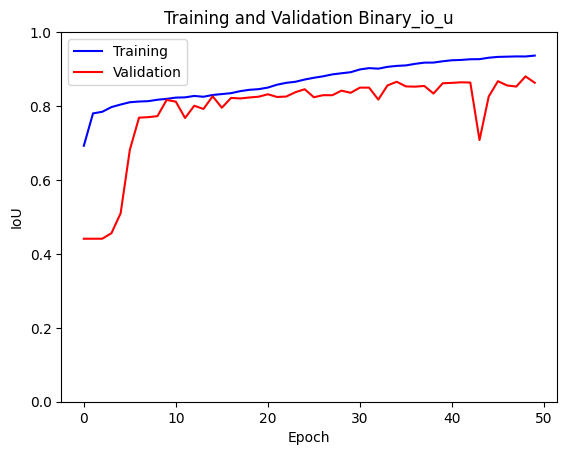

1/1 [==============================] - 0s 13ms/step
RGB_G - Avg DICE Score: 0.8404499999999999
RGB_G - Max DICE Score: 0.906
RGB_G - Min DICE Score: 0.674
RGB_G - Std DICE Score: 0.05532989698164999

--- Processing Channel: RGB_R ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 24s 280ms/step - loss: 0.4319 - binary_io_u: 0.6492 - binary_accuracy: 0.9036 - precision: 0.6028 - val_loss: 0.6743 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 281ms/step - loss: 0.3152 - binary_io_u: 0.7201 - binary_accuracy: 0.9291 - precision: 0.7293 - val_loss: 0.7035 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 22s 287ms/step - loss: 0.2863 - binary_io_u: 0.7366 - binary_accuracy: 0.9343 - precision: 0.7538 - val_loss: 0.80

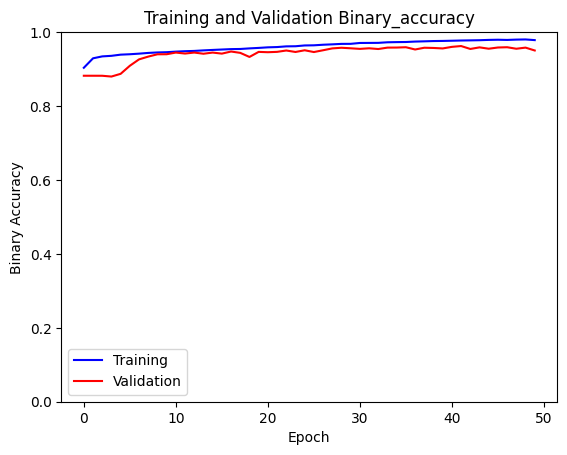

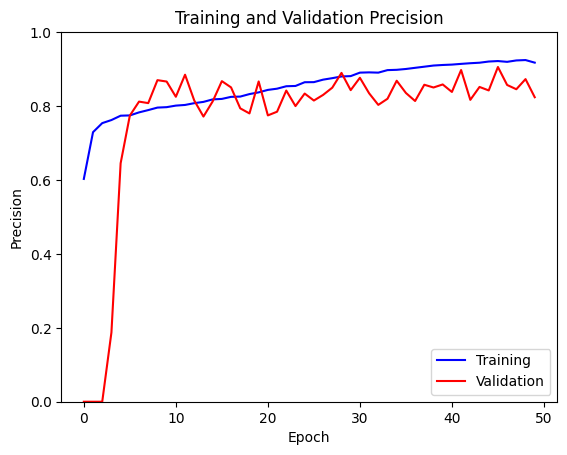

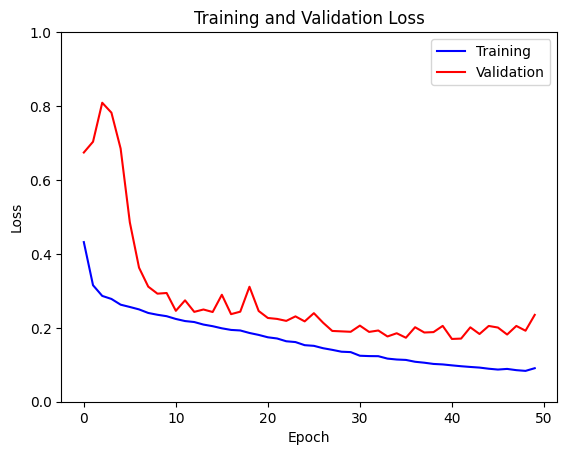

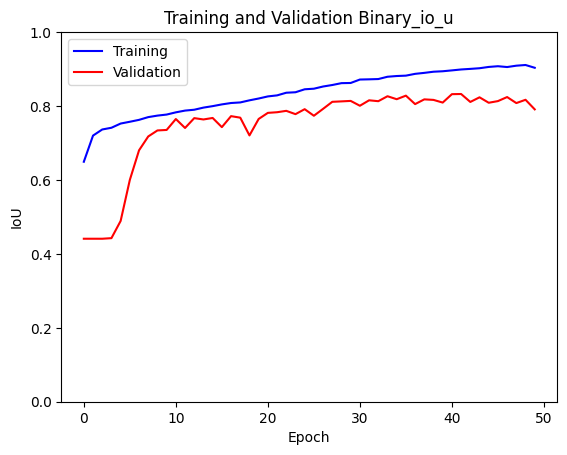

1/1 [==============================] - 0s 18ms/step
RGB_R - Avg DICE Score: 0.771775
RGB_R - Max DICE Score: 0.851
RGB_R - Min DICE Score: 0.476
RGB_R - Std DICE Score: 0.07456892365456269

--- Processing Channel: YUV_Y ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 276ms/step - loss: 0.4002 - binary_io_u: 0.7102 - binary_accuracy: 0.9155 - precision: 0.6183 - val_loss: 0.6987 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 276ms/step - loss: 0.2688 - binary_io_u: 0.7822 - binary_accuracy: 0.9452 - precision: 0.7680 - val_loss: 0.7175 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 276ms/step - loss: 0.2244 - binary_io_u: 0.7965 - binary_accuracy: 0.9499 - precision: 0.7952 - val_loss: 0.7907 - val_b

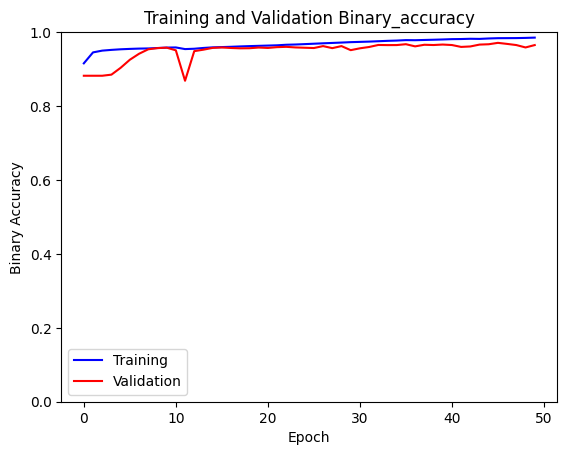

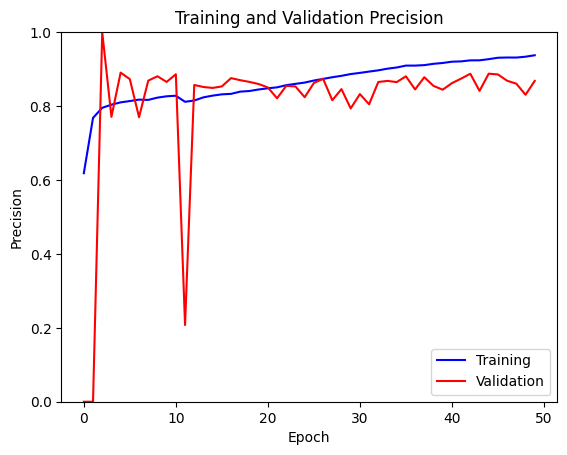

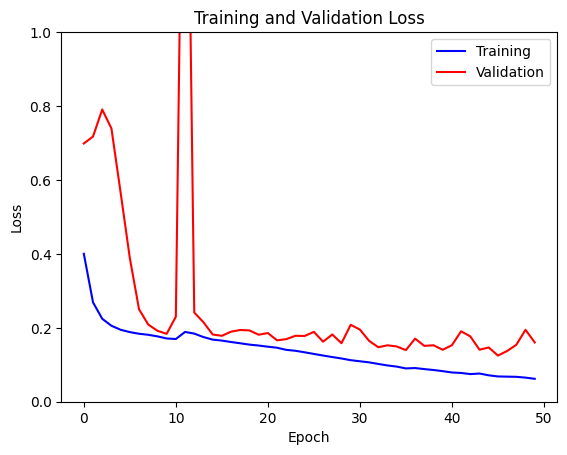

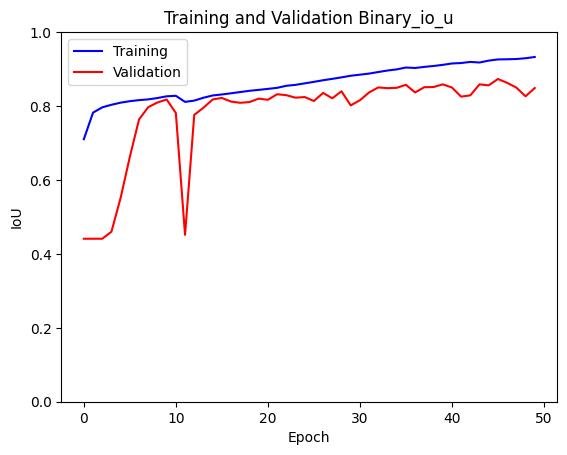

1/1 [==============================] - 0s 17ms/step
YUV_Y - Avg DICE Score: 0.8215749999999999
YUV_Y - Max DICE Score: 0.894
YUV_Y - Min DICE Score: 0.652
YUV_Y - Std DICE Score: 0.06064317253409487

--- Processing Channel: YUV_U ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 272ms/step - loss: 0.4881 - binary_io_u: 0.6156 - binary_accuracy: 0.8708 - precision: 0.4672 - val_loss: 0.6748 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 0.3452 - binary_io_u: 0.7191 - binary_accuracy: 0.9274 - precision: 0.7094 - val_loss: 0.7018 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 277ms/step - loss: 0.2992 - binary_io_u: 0.7373 - binary_accuracy: 0.9341 - precision: 0.7478 - val_loss: 0.74

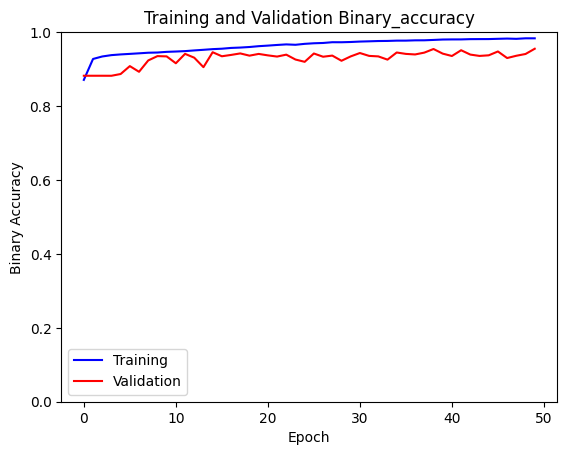

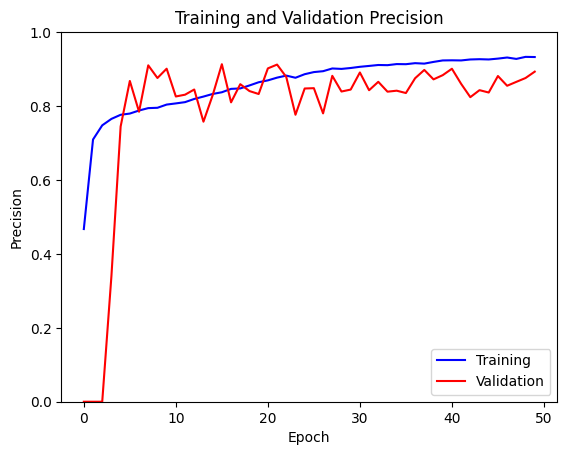

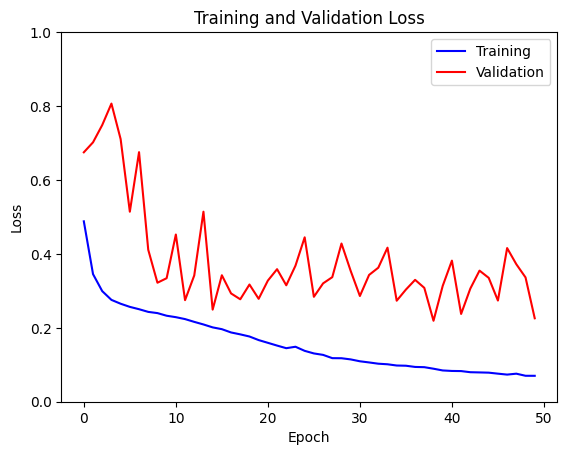

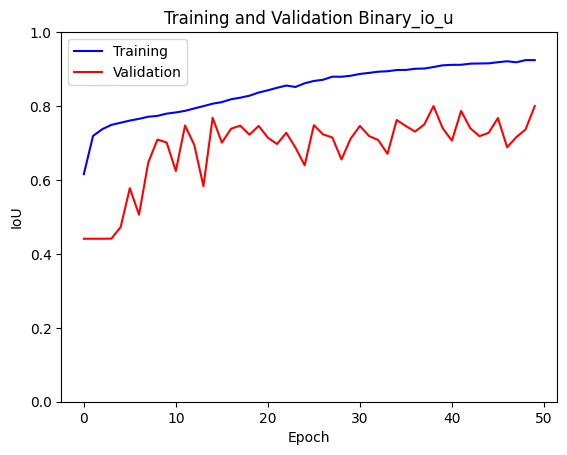

1/1 [==============================] - 0s 16ms/step
YUV_U - Avg DICE Score: 0.752675
YUV_U - Max DICE Score: 0.873
YUV_U - Min DICE Score: 0.512
YUV_U - Std DICE Score: 0.08040130207278984

--- Processing Channel: YUV_V ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 272ms/step - loss: 0.5604 - binary_io_u: 0.5408 - binary_accuracy: 0.8750 - precision: 0.4557 - val_loss: 0.6780 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 0.4811 - binary_io_u: 0.5950 - binary_accuracy: 0.8909 - precision: 0.5545 - val_loss: 0.7115 - val_binary_io_u: 0.4413 - val_binary_accuracy: 0.8819 - val_precision: 0.3871
Epoch 3/50
75/75 [==============================] - 21s 275ms/step - loss: 0.4357 - binary_io_u: 0.6278 - binary_accuracy: 0.9021 - precision: 0.6159 - val_loss: 0.7677 - val_binar

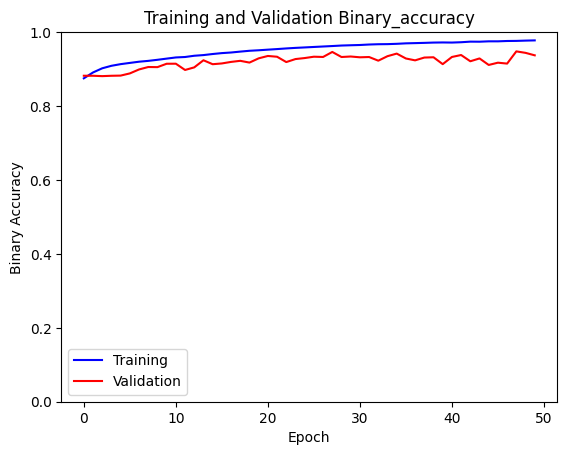

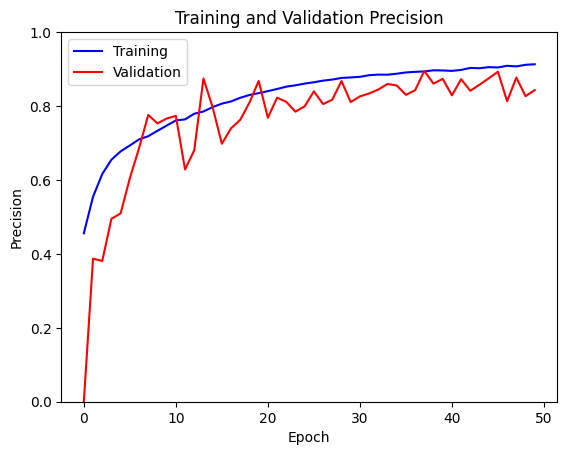

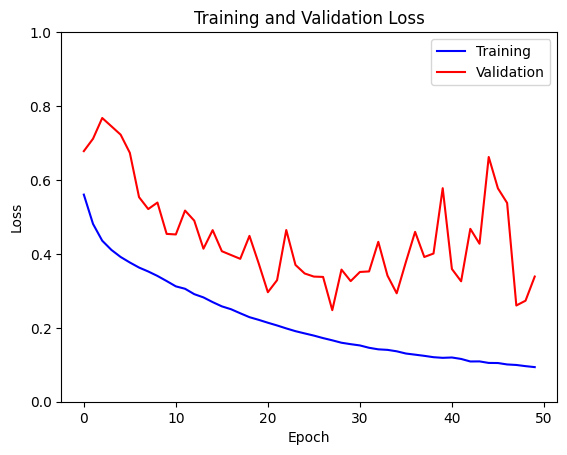

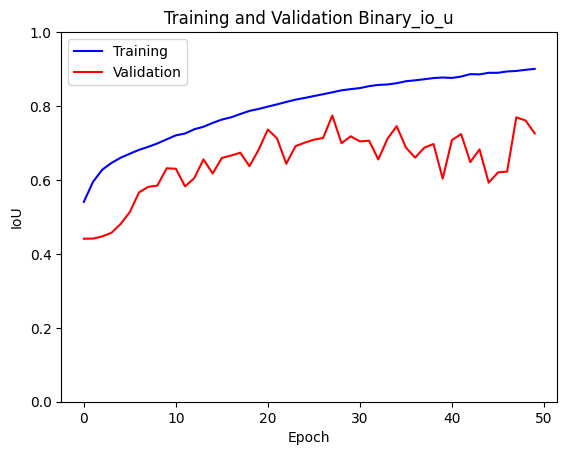

1/1 [==============================] - 0s 16ms/step
YUV_V - Avg DICE Score: 0.60975
YUV_V - Max DICE Score: 0.827
YUV_V - Min DICE Score: 0.29
YUV_V - Std DICE Score: 0.14282204836789034

--- Processing Channel: HSV_H ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 272ms/step - loss: 0.4209 - binary_io_u: 0.6632 - binary_accuracy: 0.9107 - precision: 0.6445 - val_loss: 0.6644 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 273ms/step - loss: 0.3087 - binary_io_u: 0.7249 - binary_accuracy: 0.9303 - precision: 0.7315 - val_loss: 0.7479 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 278ms/step - loss: 0.2832 - binary_io_u: 0.7404 - binary_accuracy: 0.9355 - precision: 0.7601 - val_loss: 0.8012 - val_bin

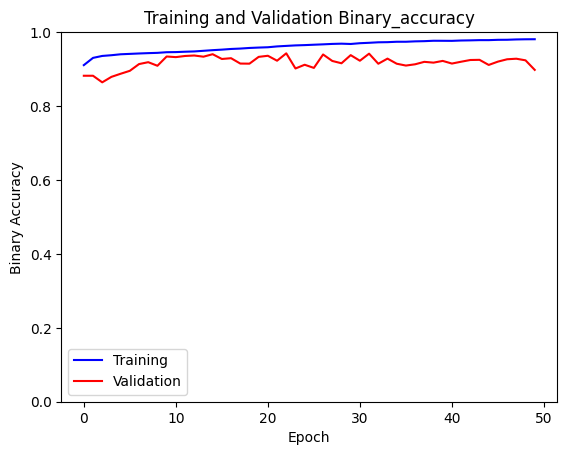

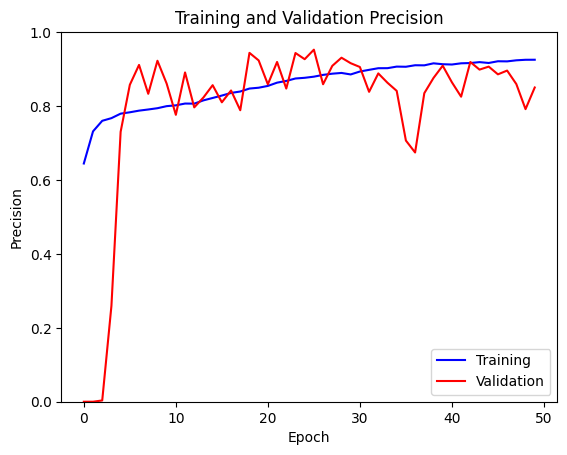

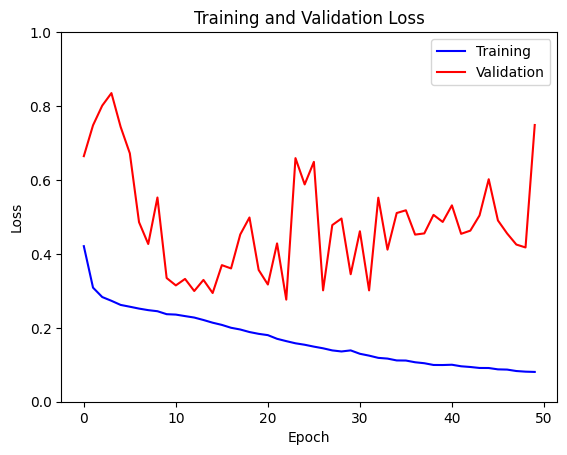

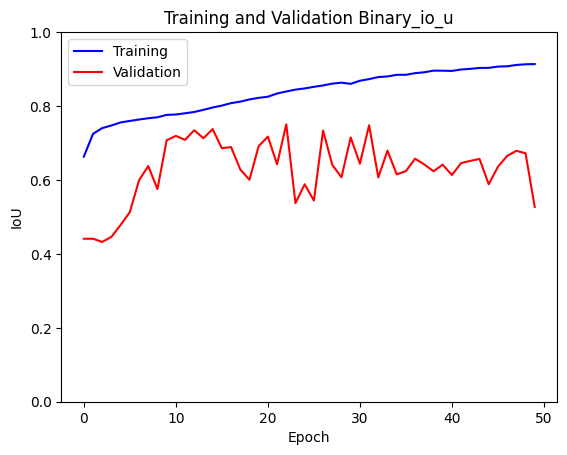

1/1 [==============================] - 0s 13ms/step
HSV_H - Avg DICE Score: 0.24312500000000004
HSV_H - Max DICE Score: 0.47
HSV_H - Min DICE Score: 0.033
HSV_H - Std DICE Score: 0.12825135233205145

--- Processing Channel: HSV_S ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 274ms/step - loss: 0.5377 - binary_io_u: 0.5746 - binary_accuracy: 0.8495 - precision: 0.4046 - val_loss: 0.6755 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 274ms/step - loss: 0.3864 - binary_io_u: 0.6887 - binary_accuracy: 0.9157 - precision: 0.6497 - val_loss: 0.6989 - val_binary_io_u: 0.4409 - val_binary_accuracy: 0.8817 - val_precision: 0.0081
Epoch 3/50
75/75 [==============================] - 21s 277ms/step - loss: 0.3281 - binary_io_u: 0.7155 - binary_accuracy: 0.9262 - precision: 0.7044 - val_loss: 0.7443 -

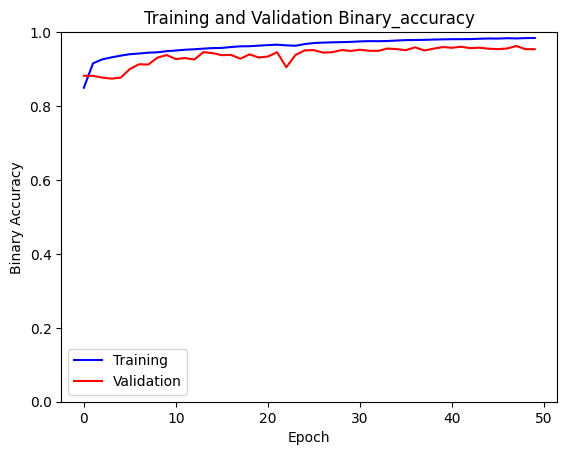

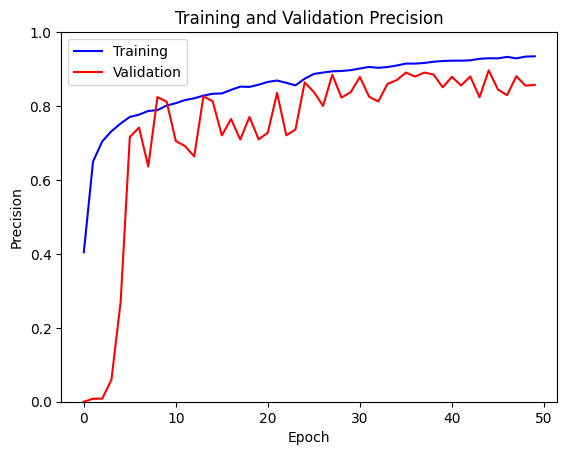

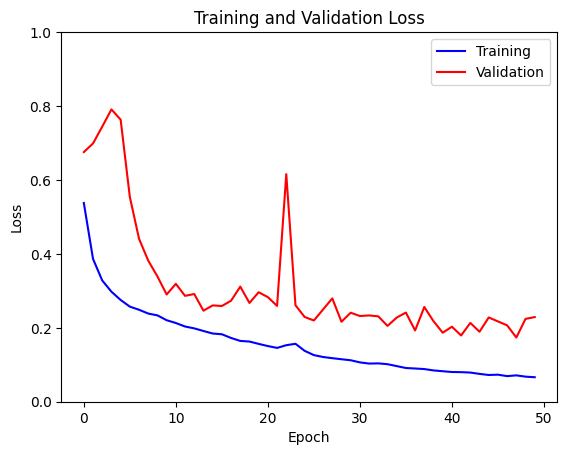

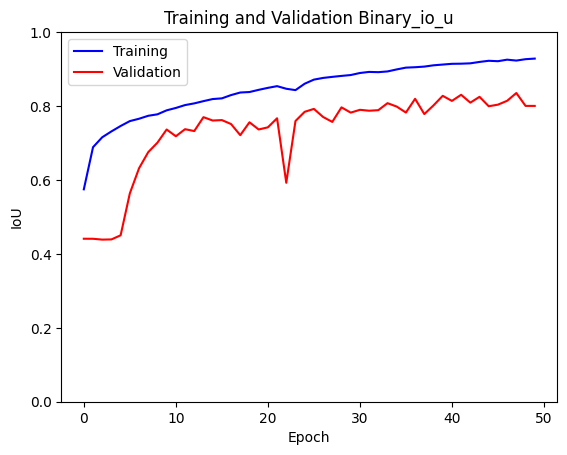

1/1 [==============================] - 0s 17ms/step
HSV_S - Avg DICE Score: 0.758425
HSV_S - Max DICE Score: 0.875
HSV_S - Min DICE Score: 0.522
HSV_S - Std DICE Score: 0.08724645766448057

--- Processing Channel: HSV_V ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 270ms/step - loss: 0.4774 - binary_io_u: 0.6258 - binary_accuracy: 0.8821 - precision: 0.5023 - val_loss: 1.3398 - val_binary_io_u: 0.4406 - val_binary_accuracy: 0.8671 - val_precision: 0.1029
Epoch 2/50
75/75 [==============================] - 20s 271ms/step - loss: 0.3378 - binary_io_u: 0.7193 - binary_accuracy: 0.9280 - precision: 0.7163 - val_loss: 0.7059 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 272ms/step - loss: 0.2977 - binary_io_u: 0.7345 - binary_accuracy: 0.9337 - precision: 0.7504 - val_loss: 0.8000 - val_binar

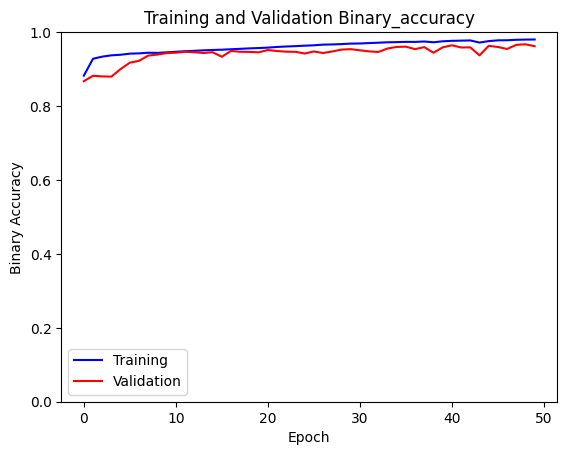

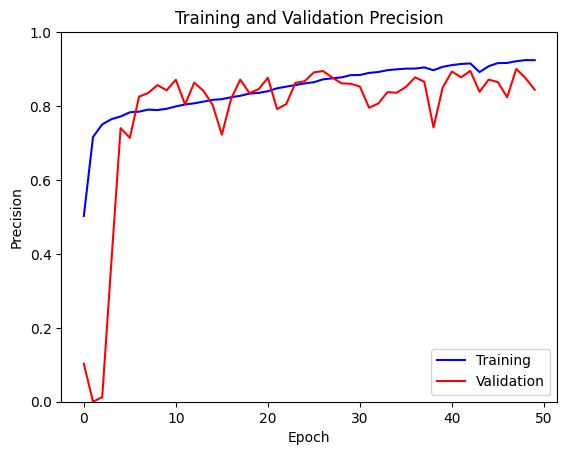

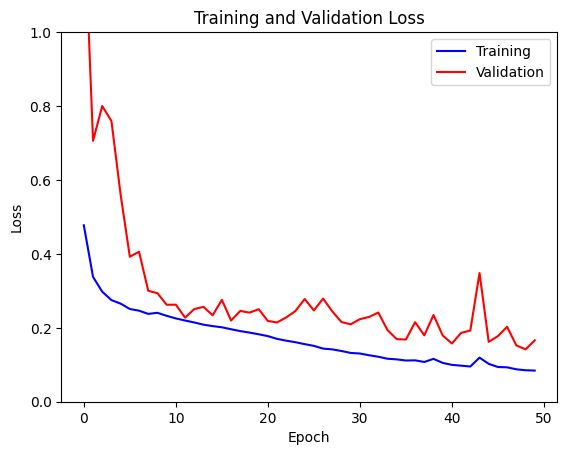

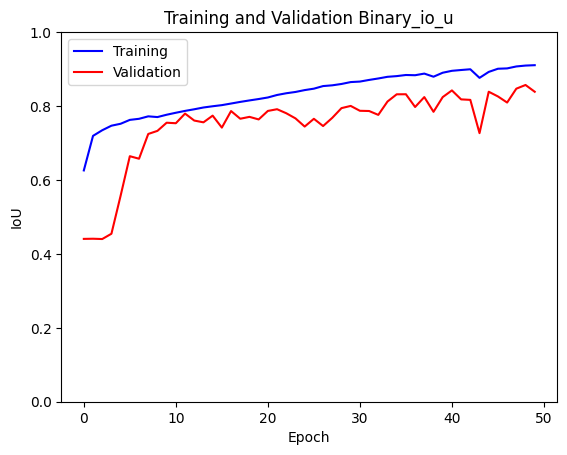

1/1 [==============================] - 0s 22ms/step
HSV_V - Avg DICE Score: 0.8309
HSV_V - Max DICE Score: 0.891
HSV_V - Min DICE Score: 0.648
HSV_V - Std DICE Score: 0.052429381075881486

--- Processing Channel: HLS_H ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 271ms/step - loss: 0.4571 - binary_io_u: 0.6344 - binary_accuracy: 0.8914 - precision: 0.5390 - val_loss: 0.6676 - val_binary_io_u: 0.4400 - val_binary_accuracy: 0.8800 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 267ms/step - loss: 0.3229 - binary_io_u: 0.7215 - binary_accuracy: 0.9292 - precision: 0.7269 - val_loss: 0.7212 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8819 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 271ms/step - loss: 0.2876 - binary_io_u: 0.7401 - binary_accuracy: 0.9352 - precision: 0.7560 - val_loss: 0.8174 - val_bi

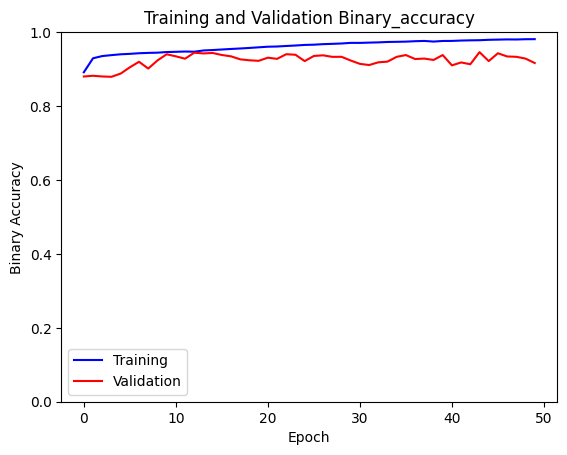

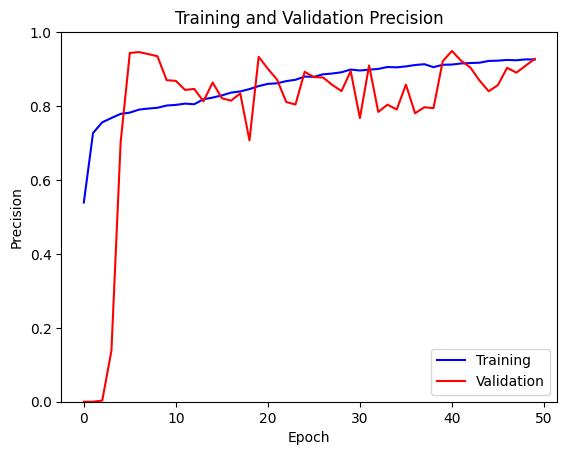

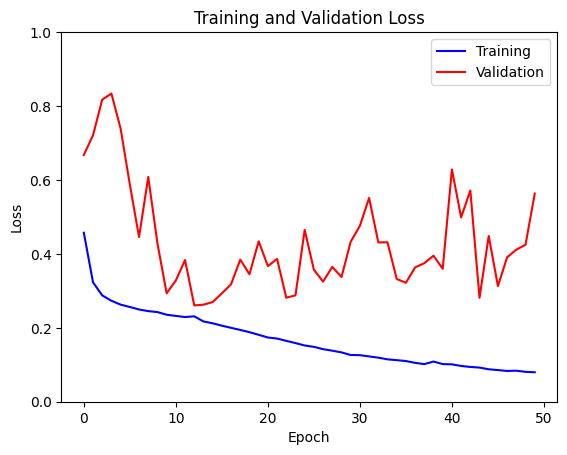

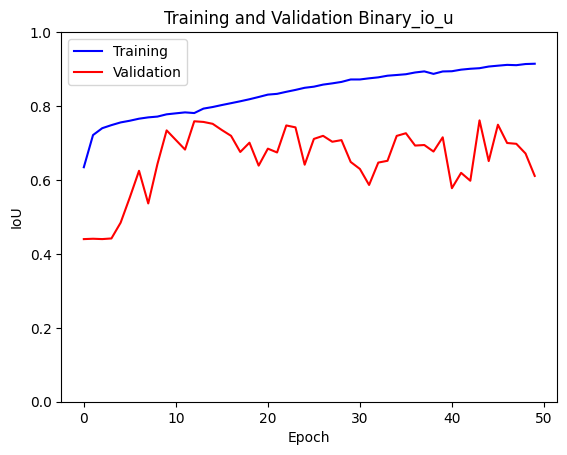

1/1 [==============================] - 0s 15ms/step
HLS_H - Avg DICE Score: 0.41662499999999997
HLS_H - Max DICE Score: 0.695
HLS_H - Min DICE Score: 0.096
HLS_H - Std DICE Score: 0.16859073039464537

--- Processing Channel: HLS_L ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 269ms/step - loss: 0.4397 - binary_io_u: 0.6541 - binary_accuracy: 0.8924 - precision: 0.5369 - val_loss: 0.6653 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 266ms/step - loss: 0.2965 - binary_io_u: 0.7527 - binary_accuracy: 0.9365 - precision: 0.7353 - val_loss: 1.9710 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 272ms/step - loss: 0.2470 - binary_io_u: 0.7763 - binary_accuracy: 0.9443 - precision: 0.7745 - val_loss: 0.7

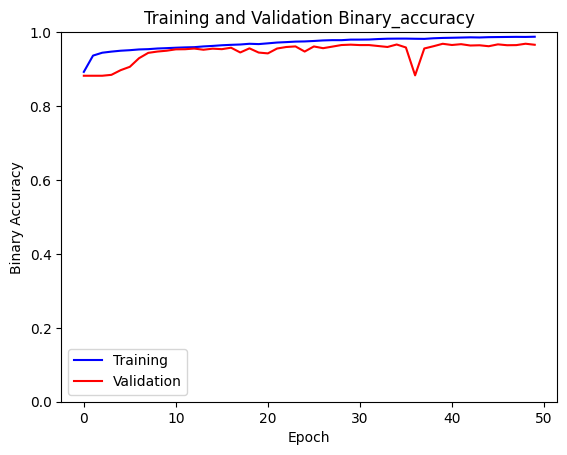

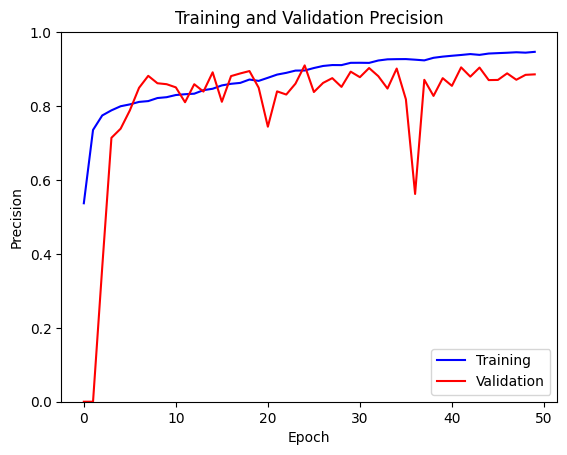

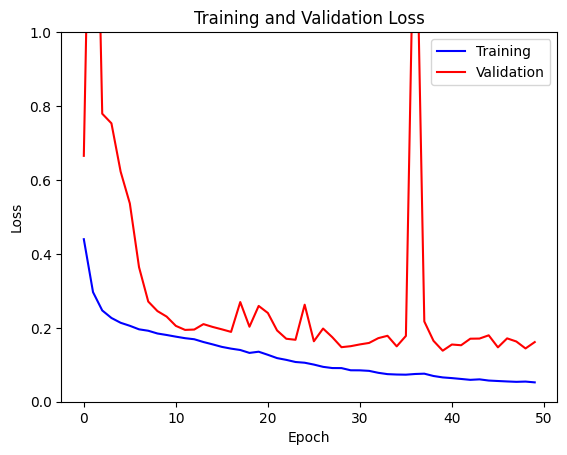

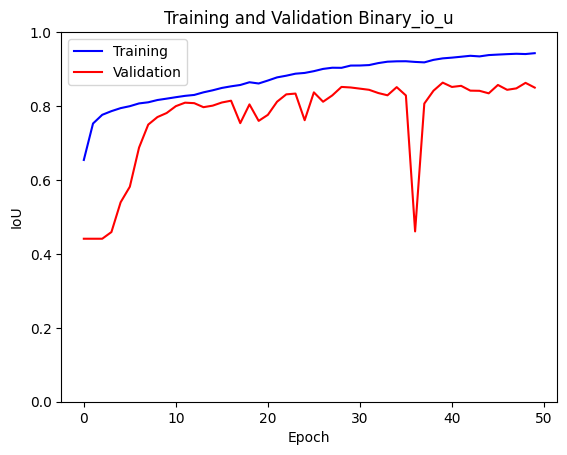

1/1 [==============================] - 0s 14ms/step
HLS_L - Avg DICE Score: 0.8306999999999999
HLS_L - Max DICE Score: 0.89
HLS_L - Min DICE Score: 0.665
HLS_L - Std DICE Score: 0.05234988061113415

--- Processing Channel: HLS_S ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 270ms/step - loss: 0.5723 - binary_io_u: 0.5416 - binary_accuracy: 0.8404 - precision: 0.3617 - val_loss: 0.6685 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 266ms/step - loss: 0.4373 - binary_io_u: 0.6428 - binary_accuracy: 0.9010 - precision: 0.5903 - val_loss: 0.7064 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 269ms/step - loss: 0.3867 - binary_io_u: 0.6676 - binary_accuracy: 0.9117 - precision: 0.6468 - val_loss: 0.737

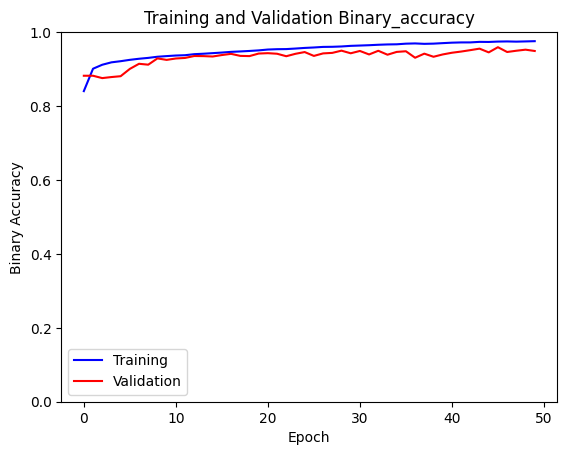

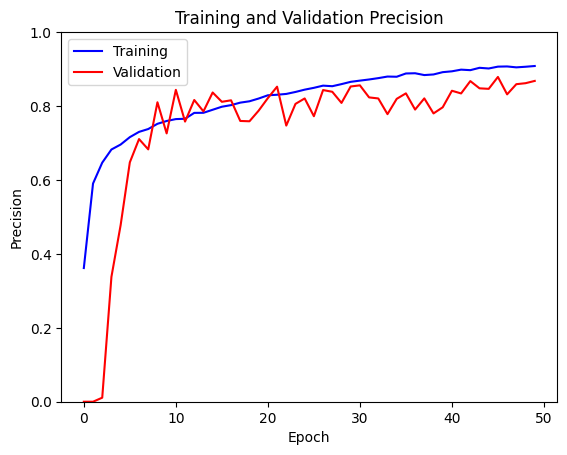

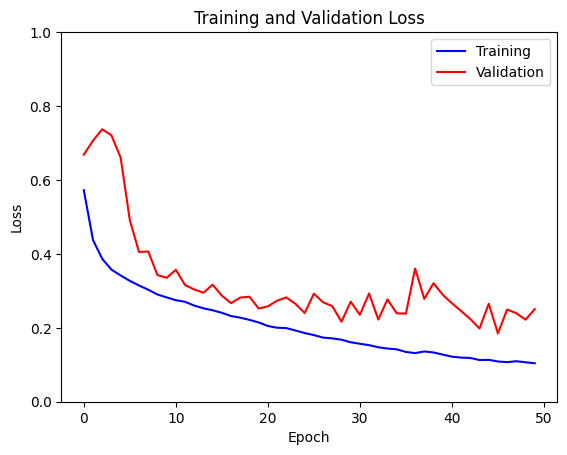

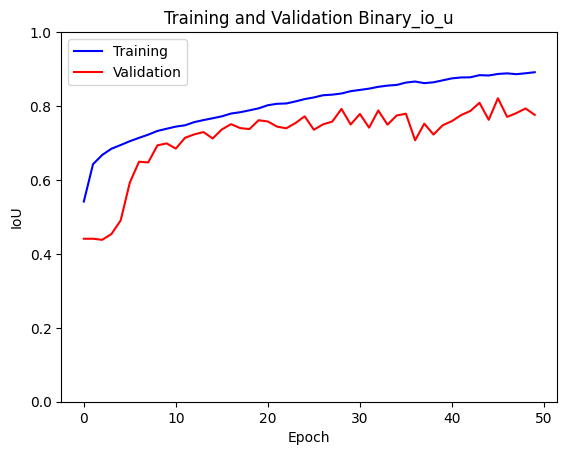

1/1 [==============================] - 0s 9ms/step
HLS_S - Avg DICE Score: 0.73085
HLS_S - Max DICE Score: 0.846
HLS_S - Min DICE Score: 0.461
HLS_S - Std DICE Score: 0.09486557594828589

--- Processing Channel: CIELab_L ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 277ms/step - loss: 0.3652 - binary_io_u: 0.7026 - binary_accuracy: 0.9161 - precision: 0.6320 - val_loss: 0.6628 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 21s 283ms/step - loss: 0.2529 - binary_io_u: 0.7722 - binary_accuracy: 0.9427 - precision: 0.7648 - val_loss: 0.7599 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 284ms/step - loss: 0.2236 - binary_io_u: 0.7878 - binary_accuracy: 0.9475 - precision: 0.7871 - val_loss: 0.8150 - val_

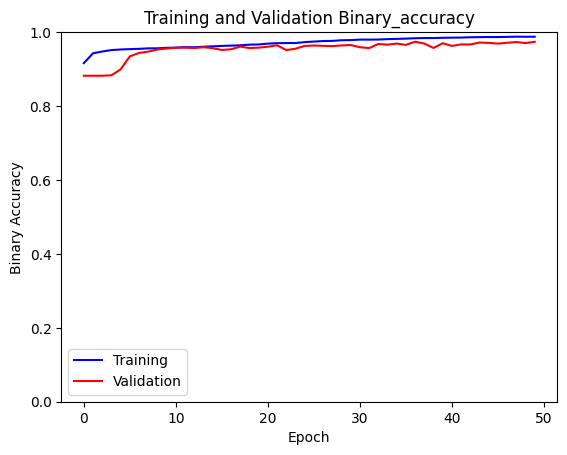

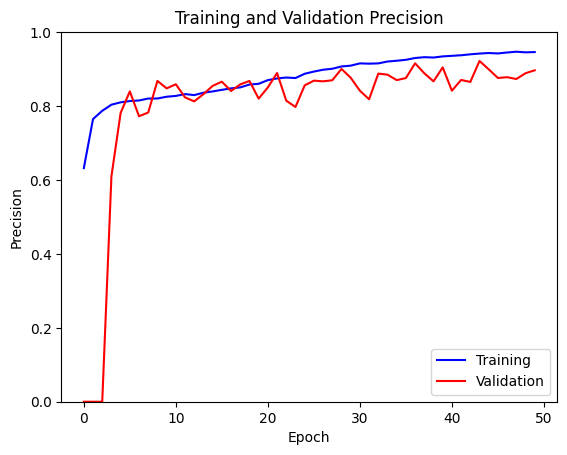

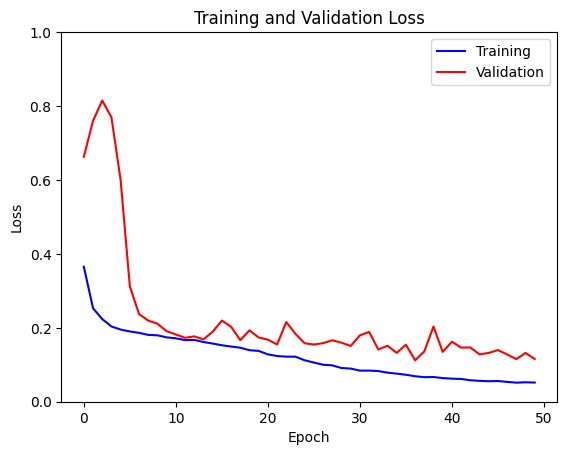

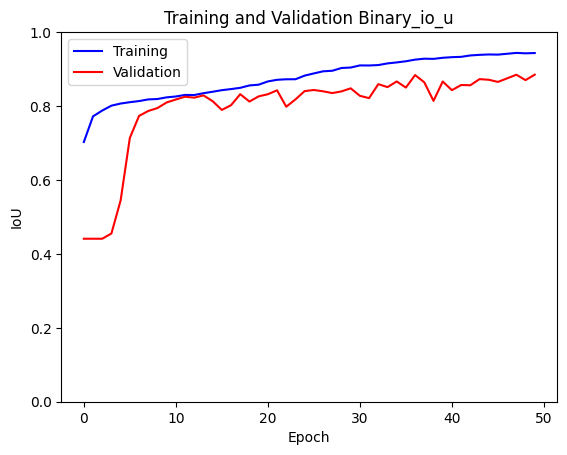

1/1 [==============================] - 0s 18ms/step
CIELab_L - Avg DICE Score: 0.8709250000000001
CIELab_L - Max DICE Score: 0.917
CIELab_L - Min DICE Score: 0.738
CIELab_L - Std DICE Score: 0.03988445029080883

--- Processing Channel: CIELab_a ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 274ms/step - loss: 0.5682 - binary_io_u: 0.5654 - binary_accuracy: 0.8446 - precision: 0.3905 - val_loss: 0.7475 - val_binary_io_u: 0.3018 - val_binary_accuracy: 0.5205 - val_precision: 0.1282
Epoch 2/50
75/75 [==============================] - 21s 274ms/step - loss: 0.4288 - binary_io_u: 0.6631 - binary_accuracy: 0.9069 - precision: 0.6128 - val_loss: 0.6794 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 277ms/step - loss: 0.3616 - binary_io_u: 0.6926 - binary_accuracy: 0.9192 - precision: 0.6762 - val

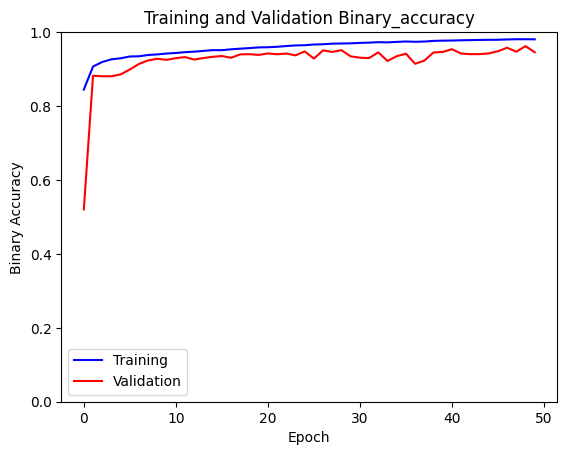

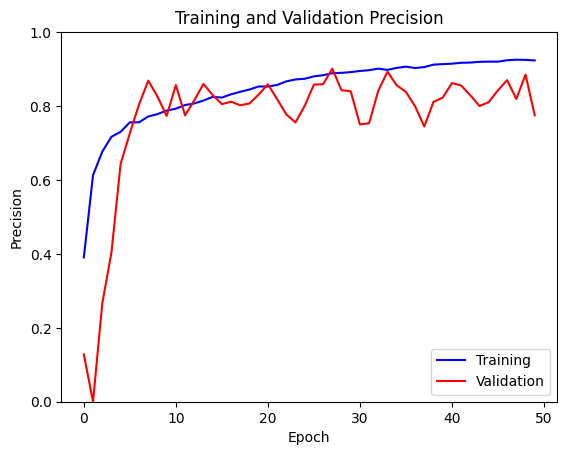

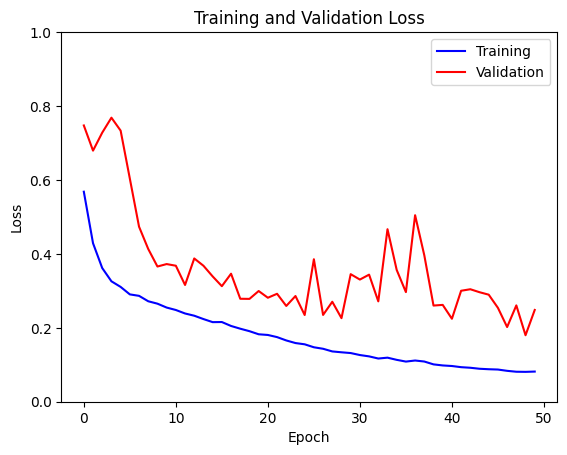

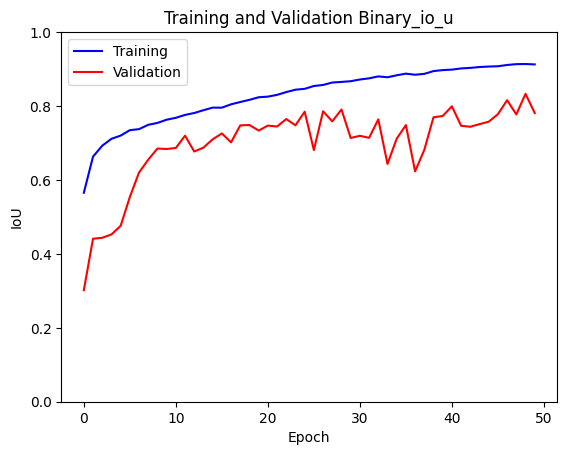

1/1 [==============================] - 0s 12ms/step
CIELab_a - Avg DICE Score: 0.7235750000000001
CIELab_a - Max DICE Score: 0.841
CIELab_a - Min DICE Score: 0.498
CIELab_a - Std DICE Score: 0.08461261356913637

--- Processing Channel: CIELab_b ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 273ms/step - loss: 0.5058 - binary_io_u: 0.5928 - binary_accuracy: 0.8682 - precision: 0.4530 - val_loss: 0.6959 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 0.3821 - binary_io_u: 0.6771 - binary_accuracy: 0.9140 - precision: 0.6532 - val_loss: 0.7133 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 21s 281ms/step - loss: 0.3397 - binary_io_u: 0.7001 - binary_accuracy: 0.9228 - precision: 0.7006 -

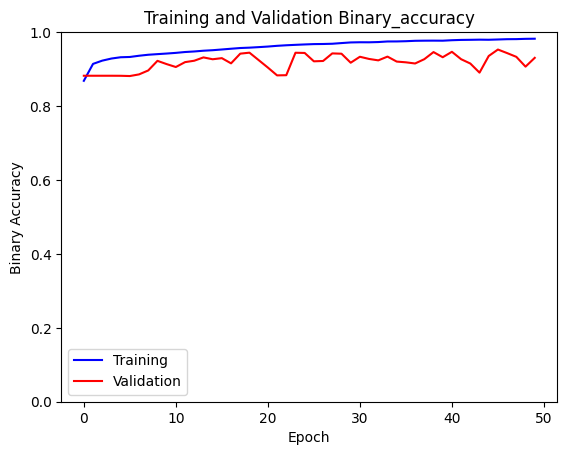

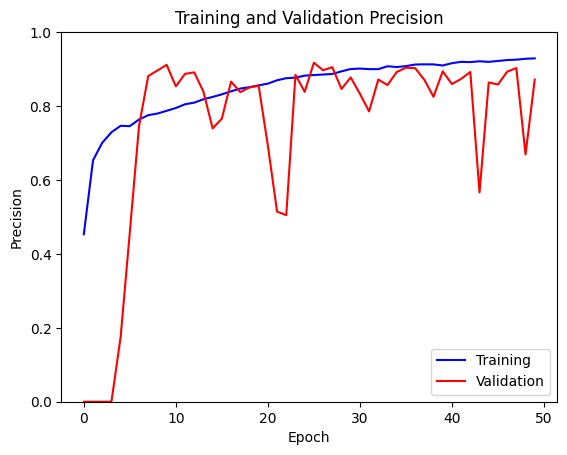

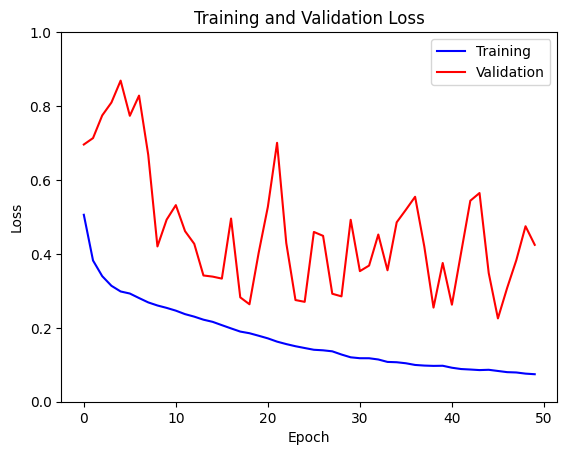

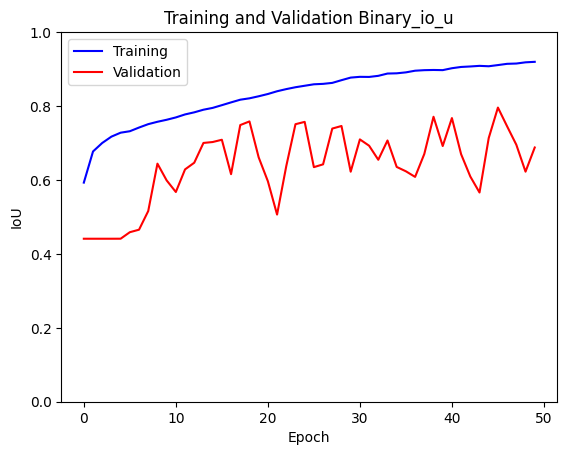

1/1 [==============================] - 0s 13ms/step
CIELab_b - Avg DICE Score: 0.548425
CIELab_b - Max DICE Score: 0.763
CIELab_b - Min DICE Score: 0.15
CIELab_b - Std DICE Score: 0.15922812055350022

--- Processing Channel: YCrCb_Y ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 268ms/step - loss: 0.3409 - binary_io_u: 0.7244 - binary_accuracy: 0.9252 - precision: 0.6750 - val_loss: 0.6587 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 19s 260ms/step - loss: 0.2370 - binary_io_u: 0.7841 - binary_accuracy: 0.9463 - precision: 0.7801 - val_loss: 0.7354 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 19s 260ms/step - loss: 0.2081 - binary_io_u: 0.7996 - binary_accuracy: 0.9509 - precision: 0.7996 - val_loss: 0

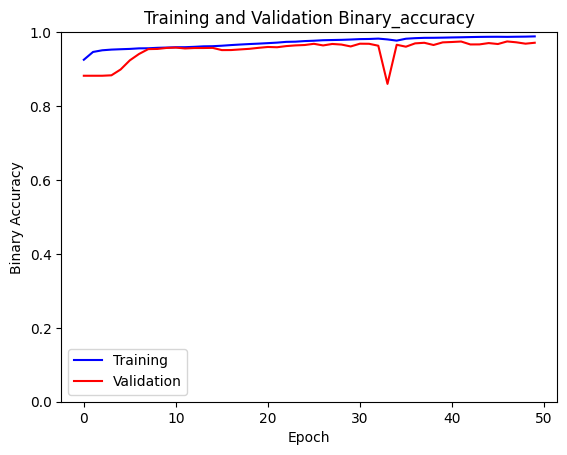

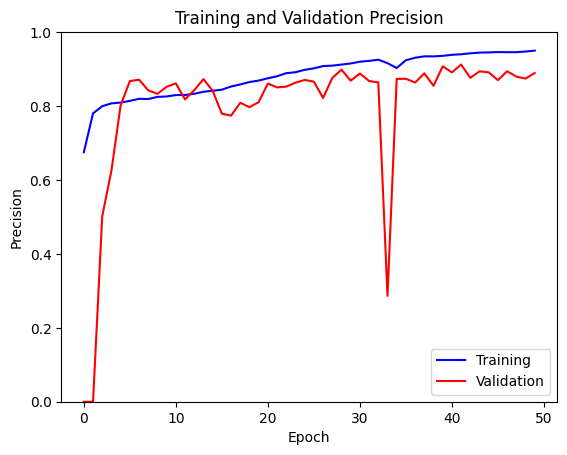

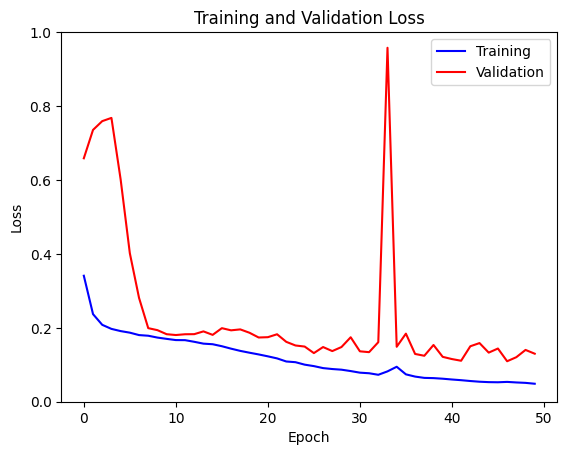

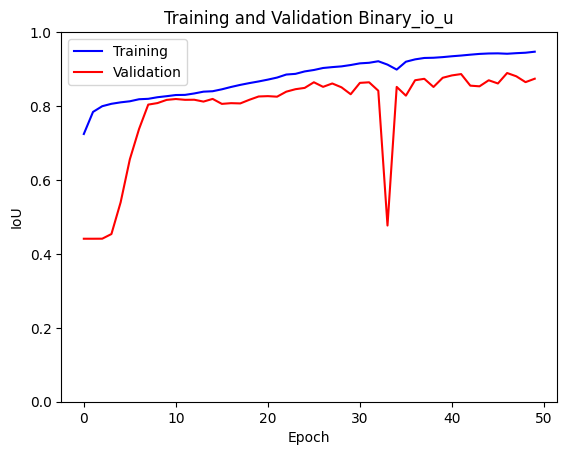

1/1 [==============================] - 0s 14ms/step
YCrCb_Y - Avg DICE Score: 0.8578749999999999
YCrCb_Y - Max DICE Score: 0.916
YCrCb_Y - Min DICE Score: 0.709
YCrCb_Y - Std DICE Score: 0.04611896979551908

--- Processing Channel: YCrCb_Cr ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 268ms/step - loss: 0.6191 - binary_io_u: 0.5109 - binary_accuracy: 0.8326 - precision: 0.3130 - val_loss: 2.0321 - val_binary_io_u: 0.1057 - val_binary_accuracy: 0.1915 - val_precision: 0.1195
Epoch 2/50
75/75 [==============================] - 19s 259ms/step - loss: 0.5103 - binary_io_u: 0.5871 - binary_accuracy: 0.8831 - precision: 0.5084 - val_loss: 0.6942 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 19s 260ms/step - loss: 0.4567 - binary_io_u: 0.6170 - binary_accuracy: 0.8963 - precision: 0.5793 - val_los

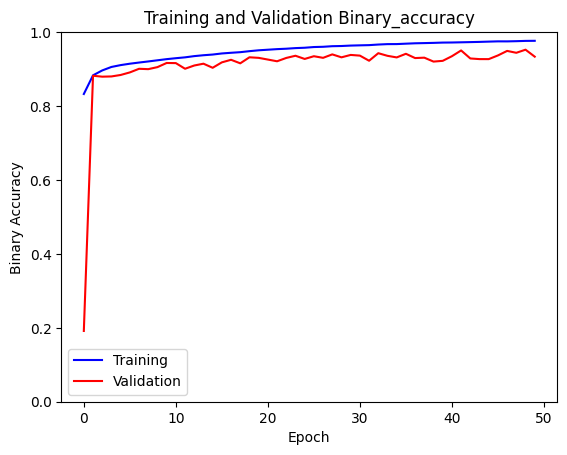

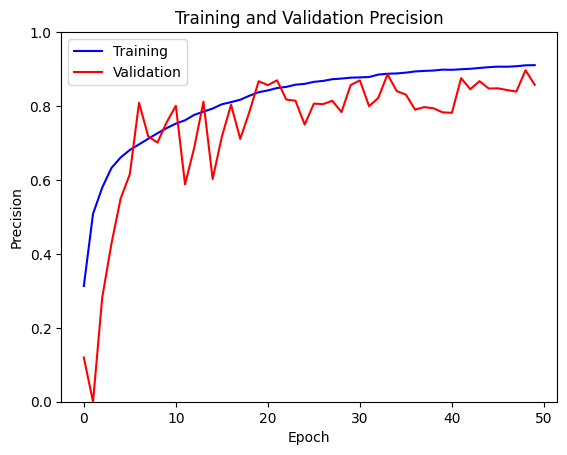

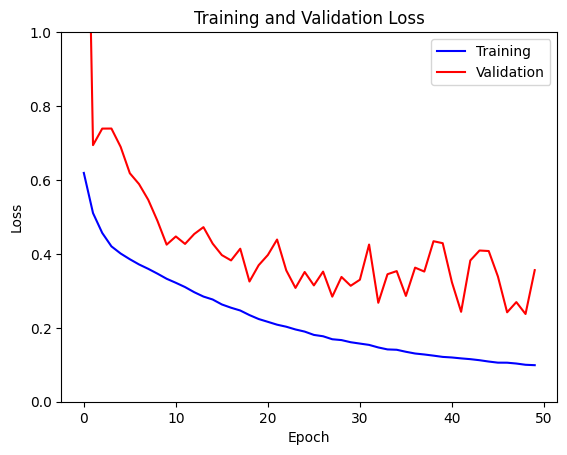

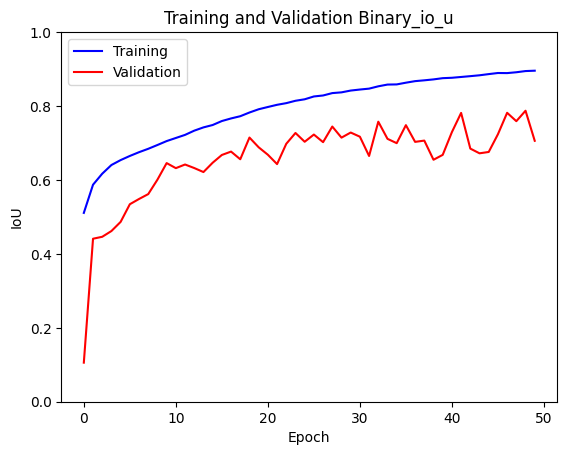

1/1 [==============================] - 0s 18ms/step
YCrCb_Cr - Avg DICE Score: 0.5776
YCrCb_Cr - Max DICE Score: 0.81
YCrCb_Cr - Min DICE Score: 0.279
YCrCb_Cr - Std DICE Score: 0.1529617272392019

--- Processing Channel: YCrCb_Cb ---
Train shape: (600, 256, 256, 1), Val shape: (160, 256, 256, 1), Test shape: (40, 256, 256, 1)
Epoch 1/50
75/75 [==============================] - 23s 269ms/step - loss: 0.5549 - binary_io_u: 0.5944 - binary_accuracy: 0.8509 - precision: 0.4203 - val_loss: 4.0136 - val_binary_io_u: 0.0748 - val_binary_accuracy: 0.1426 - val_precision: 0.1182
Epoch 2/50
75/75 [==============================] - 20s 261ms/step - loss: 0.4102 - binary_io_u: 0.7070 - binary_accuracy: 0.9210 - precision: 0.6673 - val_loss: 0.6721 - val_binary_io_u: 0.4410 - val_binary_accuracy: 0.8820 - val_precision: 0.0000e+00
Epoch 3/50
75/75 [==============================] - 20s 266ms/step - loss: 0.3331 - binary_io_u: 0.7278 - binary_accuracy: 0.9302 - precision: 0.7218 - val_loss: 0.7144 

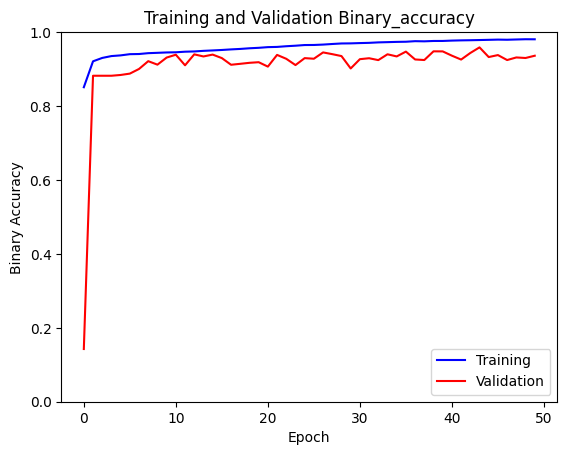

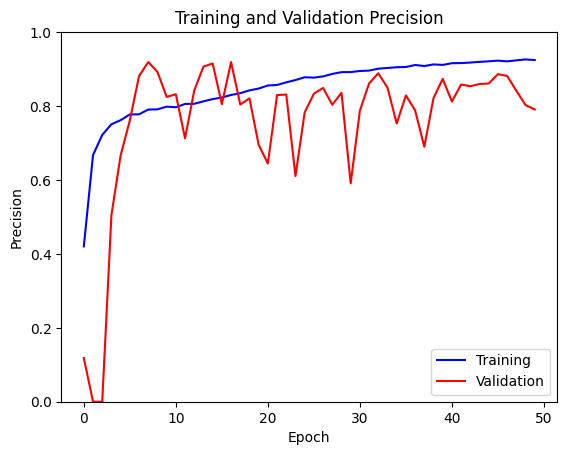

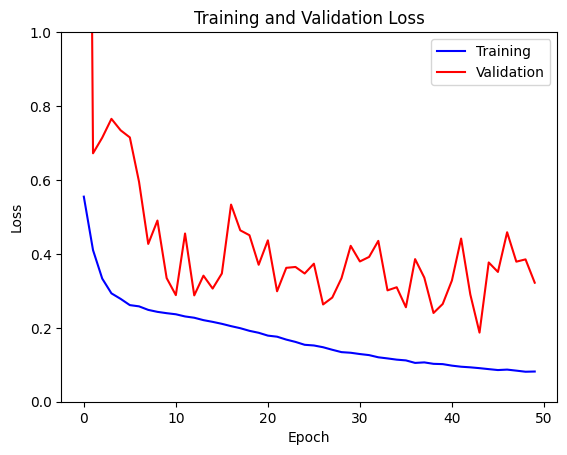

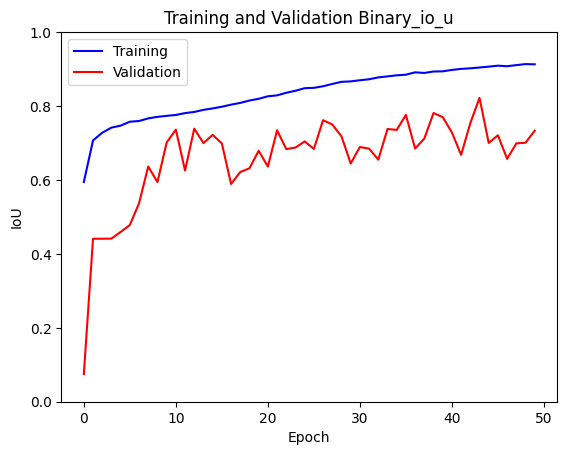

1/1 [==============================] - 0s 17ms/step
YCrCb_Cb - Avg DICE Score: 0.64065
YCrCb_Cb - Max DICE Score: 0.817
YCrCb_Cb - Min DICE Score: 0.292
YCrCb_Cb - Std DICE Score: 0.12528817781418963


In [4]:
channels = ['gray', 'RGB_B', 'RGB_G', 'RGB_R', 'YUV_Y', 'YUV_U', 'YUV_V',
            'HSV_H', 'HSV_S', 'HSV_V', 'HLS_H', 'HLS_L', 'HLS_S',
            'CIELab_L', 'CIELab_a', 'CIELab_b', 'YCrCb_Y', 'YCrCb_Cr', 'YCrCb_Cb']

# Common target mask directories
mask_train_dir = 'C:/Users/User/Desktop/Helevorn/data/segmentation/train'
mask_val_dir = 'C:/Users/User/Desktop/Helevorn/data/segmentation/val'
mask_test_dir = 'C:/Users/User/Desktop/Helevorn/data/segmentation/test'

Y_train = load_masks(mask_train_dir)
Y_val = load_masks(mask_val_dir)
Y_test = load_masks(mask_test_dir)

for channel in channels:
    print(f"\n--- Processing Channel: {channel} ---")
    
    img_train_dir = f'C:/Users/User/Desktop/Helevorn/data/chan/{channel}/images/train'
    img_val_dir = f'C:/Users/User/Desktop/Helevorn/data/chan/{channel}/images/val'
    img_test_dir = f'C:/Users/User/Desktop/Helevorn/data/chan/{channel}/images/test'
    
    # Load channel-specific input images
    X_train = load_images(img_train_dir)
    X_val = load_images(img_val_dir)
    X_test = load_images(img_test_dir)
    
    print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
    
    model = attention_unet((256, 256, 1))
    
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        batch_size=8,
                        epochs=50)
    
    # Plot metrics
    plot_metrics(history, 'binary_accuracy', 'Binary Accuracy', [0, 1])
    plot_metrics(history, 'precision', 'Precision', [0, 1])
    plot_metrics(history, 'loss', 'Loss', [0, 1])
    plot_metrics(history, 'binary_io_u', 'IoU', [0, 1])
    
    # Evaluate and print DICE
    dice_scores = [DICE_COE(model.predict(np.expand_dims(x, 0)).squeeze(), y.squeeze())
                   for x, y in zip(X_test, Y_test)]

    print(f"{channel} - Avg DICE Score:", np.mean(dice_scores))
    print(f"{channel} - Max DICE Score:", np.max(dice_scores))
    print(f"{channel} - Min DICE Score:", np.min(dice_scores))
    print(f"{channel} - Std DICE Score:", np.std(dice_scores))
    
    # Save model
    model.save(f'retinal_{channel}.keras')

    # Cleanup
    del X_train, X_val, X_test, model
    K.clear_session()

In [11]:
def attention_unet(input_shape=(None, None, 1)):
    inputs = L.Input(input_shape)
    c0, p0 = encoder_block(inputs, 32)
    c1, p1 = encoder_block(p0, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    c5 = conv_block(p4, 1024)
    u1 = decoder_block(c5, c4, 512)
    u2 = decoder_block(u1, c3, 256)
    u3 = decoder_block(u2, c2, 128)
    u4 = decoder_block(u3, c1, 64)
    u5 = decoder_block(u4, c0, 32)
    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(u5)

    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(0.001),
              loss=combined_dice_bce_loss,
              metrics=[
                  BinaryIoU(target_class_ids=[0, 1], threshold=0.5),
                  BinaryAccuracy(),
                  Precision()
              ])

    return model

for channel in channels:
    model_path = f"retinal_{channel}.keras"
    weights_path = f"model_weights_{channel}.h5"
    
    print(f"Processing {channel}...")

    # Load fixed model with locked input shape
    fixed_model = load_model(
        model_path,
        custom_objects={
            "combined_dice_bce_loss": combined_dice_bce_loss,
            "dice_loss": dice_loss,
            "BinaryIoU": tf.keras.metrics.BinaryIoU,
            "BinaryAccuracy": tf.keras.metrics.BinaryAccuracy,
            "Precision": tf.keras.metrics.Precision
        }
    )

    # Save weights only
    fixed_model.save_weights(weights_path)
    print(f"Saved weights to {weights_path}")


Processing gray...
Saved weights to model_weights_gray.h5
Processing RGB_B...
Saved weights to model_weights_RGB_B.h5
Processing RGB_G...
Saved weights to model_weights_RGB_G.h5
Processing RGB_R...
Saved weights to model_weights_RGB_R.h5
Processing YUV_Y...
Saved weights to model_weights_YUV_Y.h5
Processing YUV_U...
Saved weights to model_weights_YUV_U.h5
Processing YUV_V...
Saved weights to model_weights_YUV_V.h5
Processing HSV_H...
Saved weights to model_weights_HSV_H.h5
Processing HSV_S...
Saved weights to model_weights_HSV_S.h5
Processing HSV_V...
Saved weights to model_weights_HSV_V.h5
Processing HLS_H...
Saved weights to model_weights_HLS_H.h5
Processing HLS_L...
Saved weights to model_weights_HLS_L.h5
Processing HLS_S...
Saved weights to model_weights_HLS_S.h5
Processing CIELab_L...
Saved weights to model_weights_CIELab_L.h5
Processing CIELab_a...
Saved weights to model_weights_CIELab_a.h5
Processing CIELab_b...
Saved weights to model_weights_CIELab_b.h5
Processing YCrCb_Y...
Sa

In [26]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    prec = tp / (tp + fp + 1e-6)
    spec = tn / (tn + fp + 1e-6)

    return acc, prec, spec

1/1 [==============================] - 0s 413ms/step
Dice coefficient : 0.8160
Accuracy         : 0.9658
Precision        : 0.9089
Specificity      : 0.9915


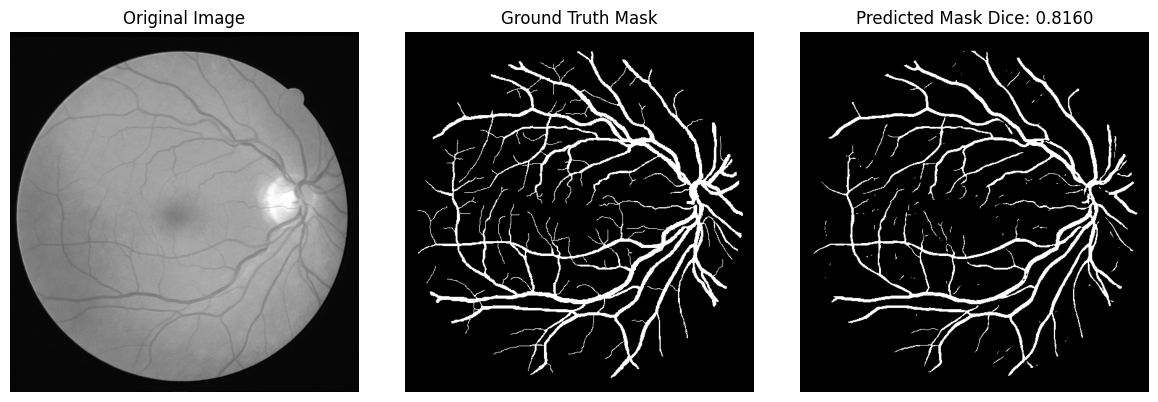

In [28]:
# Rebuild the flexible model
flex_model = attention_unet(input_shape=(None, None, 1))

# Load weights
flex_model.load_weights("model_weights_gray.h5")

# Load and preprocess image
img_path = "C:/Users/User/Desktop/Fangorn/data/numeric/images/grey/1.png"
img = load_img(img_path, color_mode="grayscale")
img = img_to_array(img)  # shape: (H, W, 1)
h, w = img.shape[:2]

# Pad to multiple of 32
pad_h = (32 - h % 32) % 32
pad_w = (32 - w % 32) % 32
img_padded = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode="constant")

img_padded = img_padded / 255.0
img_input = np.expand_dims(img_padded, axis=0)  # (1, H, W, 1)

# Predict
pred = flex_model.predict(img_input)[0, ..., 0]
pred = pred[:h, :w]  # Crop back to original size

# Threshold
binary_mask = (pred > 0.5).astype(np.uint8)

# Load ground truth mask (must match predicted shape)
gt_mask = load_img("C:/Users/User/Desktop/Fangorn/data/numeric/gt/1.png", color_mode="grayscale")
gt_mask = img_to_array(gt_mask).squeeze()  # shape: (H, W)
gt_mask = cv2.resize(gt_mask, (w, h))  # Resize if needed
gt_mask = (gt_mask > 127).astype(np.uint8)  # Binarize if it's 8-bit

dice_score = DICE_COE(gt_mask, binary_mask)

acc, prec, spec = calculate_metrics(gt_mask, binary_mask)

print(f"Dice coefficient : {dice_score:.4f}")
print(f"Accuracy         : {acc:.4f}")
print(f"Precision        : {prec:.4f}")
print(f"Specificity      : {spec:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap="gray")
plt.title(f"Predicted Mask Dice: {dice_score:.4f}")
plt.axis("off")

plt.tight_layout()
plt.show()